In [1]:
import pandas as pd

# TripAdvisor otel yorumları veri setini yükleyelim
df = pd.read_csv("hotelReviews.csv")
print("Toplam yorum sayısı:", len(df))

# Veri yapısını görmek için ilk birkaç satırı gösterelim
df.head(5)


Toplam yorum sayısı: 68785


,hotel_url,profile_reviewer,rating,review_title,review_text,date
0,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/knight07,5,Would definitely recommend,Very close to mall and many restaurants. Great...,Nov 2023
1,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/tripswaytourism,5,"‪Radisson Collection Hotel, Vadistanbul‬","May the peace, blessings, and mercy of God be ...",Oct 2023
2,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/FredericF207,5,Lovely stay and amazing view,"Amazing staff and service, we have stayed for ...",Aug 2023
3,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/alevit595800,4,exallent,staff very helpful friendly and polite!good lo...,Aug 2023
4,/Hotel_Review-g293974-d15235441-Reviews-Radiss...,/Profile/don3ziz,5,Good hotel next to the mall,Good location next to tge mall and not far fro...,Aug 2023


C:\Users\PC\AppData\Local\Temp\ipykernel_2964\643229241.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="rating", ax=axes[0], palette="Blues_r")


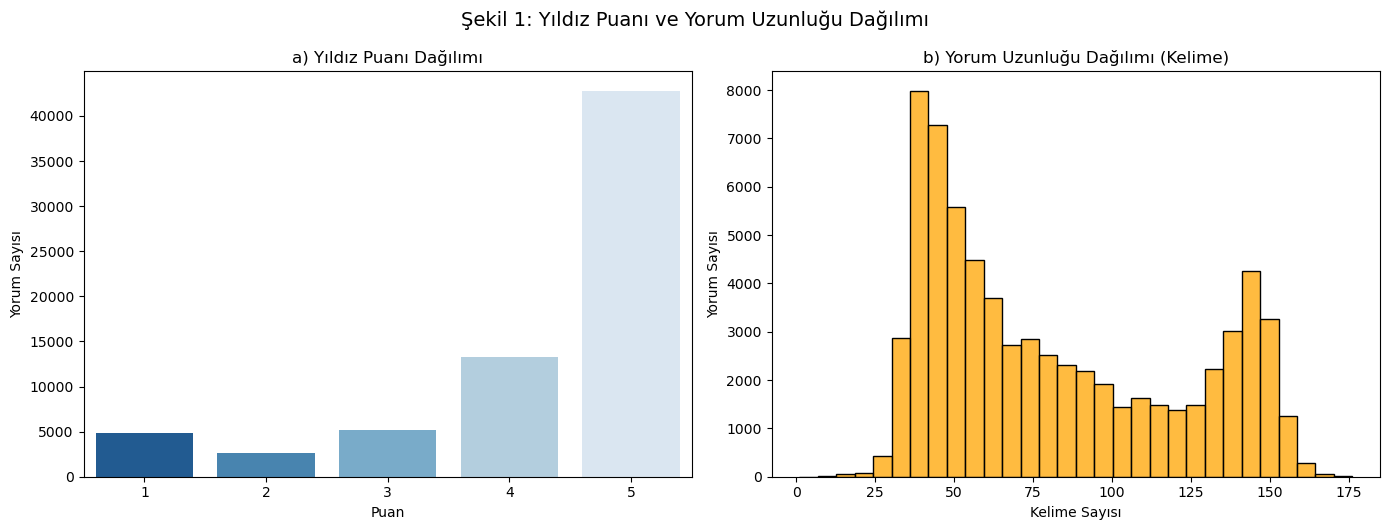

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Yorum uzunluklarını hesapla
df["review_length"] = df["review_text"].apply(lambda x: len(str(x).split()))

# 1. madde: Yıldız puanı ve yorum uzunluğu dağılımları
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# a) Yıldız puanı dağılımı
sns.countplot(data=df, x="rating", ax=axes[0], palette="Blues_r")
axes[0].set_title("a) Yıldız Puanı Dağılımı")
axes[0].set_xlabel("Puan")
axes[0].set_ylabel("Yorum Sayısı")

# b) Yorum uzunluğu dağılımı
sns.histplot(df["review_length"], bins=30, kde=False, ax=axes[1], color="orange")
axes[1].set_title("b) Yorum Uzunluğu Dağılımı (Kelime)")
axes[1].set_xlabel("Kelime Sayısı")
axes[1].set_ylabel("Yorum Sayısı")

plt.tight_layout()
plt.suptitle("Şekil 1: Yıldız Puanı ve Yorum Uzunluğu Dağılımı", fontsize=14, y=1.05)
plt.show()


In [3]:
# Her bir yorumun kelime sayısını hesaplayalım
review_lengths = df['review_text'].astype(str).apply(lambda x: len(x.split()))

# Yorum uzunluklarına dair özet istatistikler (ortalama, medyan, yüzde 95, 99)
print(review_lengths.describe(percentiles=[0.5, 0.95, 0.99]))


count    68785.000000
mean        81.386407
std         39.779297
min          1.000000
50%         69.000000
95%        149.000000
99%        156.000000
max        176.000000
Name: review_text, dtype: float64


In [4]:
import re
from collections import Counter

# Tüm yorumları tek bir büyük metin haline getirelim ve küçültelim
all_text = " ".join(df['review_text'].astype(str)).lower()

# Noktalama işaretlerini kaldır (kelime frekansı analizi için)
all_text_clean = re.sub(r"[^\w\s]", " ", all_text)
words = all_text_clean.split()

# Kelime frekanslarını say
freq = Counter(words)
print("En sık geçen 10 kelime (durak kelimeler dahil):", freq.most_common(10))

# İngilizce durak kelimelerini çıkarıp tekrar en sık kelimelere bakalım
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_nostop = [w for w in words if w not in stop_words]
freq_nostop = Counter(words_nostop)
print("En sık geçen 10 kelime (durak kelimeler hariç):", freq_nostop.most_common(10))


En sık geçen 10 kelime (durak kelimeler dahil): [('the', 339160), ('and', 232464), ('to', 144903), ('a', 127123), ('is', 106371), ('was', 100065), ('hotel', 94000), ('in', 91255), ('i', 82929), ('of', 76599)]
En sık geçen 10 kelime (durak kelimeler hariç): [('hotel', 94000), ('room', 46955), ('staff', 42162), ('good', 36261), ('breakfast', 33437), ('location', 28800), ('clean', 28279), ('stay', 26911), ('great', 26093), ('rooms', 25706)]


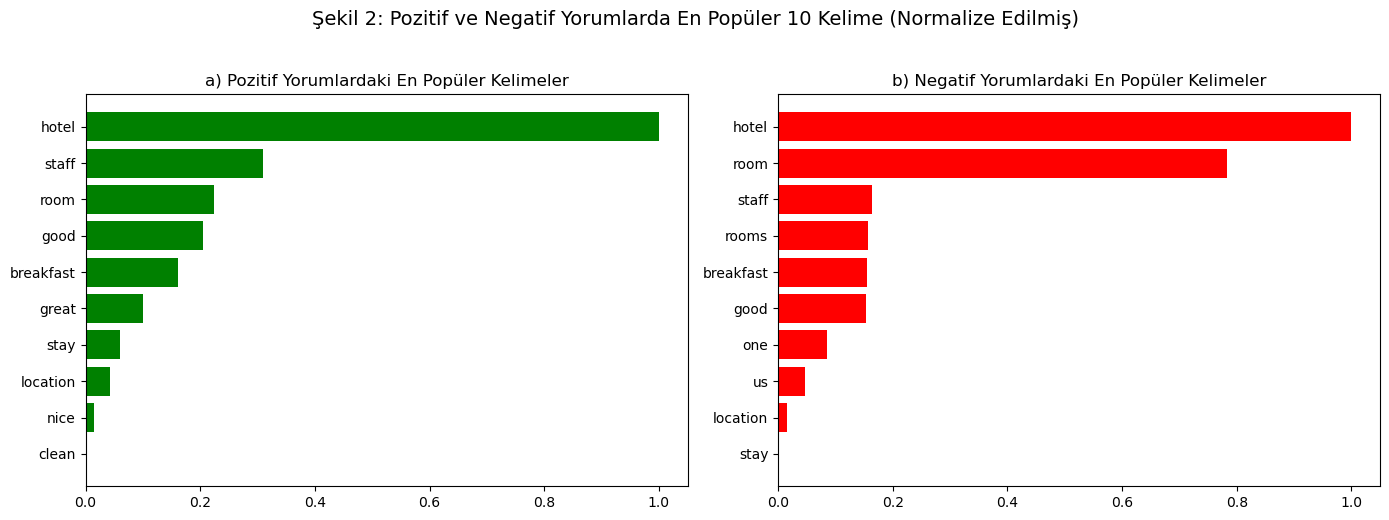

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def preprocess_text(text):
    tokens = str(text).lower().split()
    filtered = [word for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(filtered)

df["clean_text"] = df["review_text"].apply(preprocess_text)

# Pozitif ve negatif yorumları ayır
positive_reviews = df[df["rating"] >= 4]["clean_text"]
negative_reviews = df[df["rating"] <= 3]["clean_text"]

# CountVectorizer ile en sık geçen 10 kelime
def get_top_words(text_series, top_n=10):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text_series)
    total_counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    word_freq = dict(zip(vocab, total_counts))
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Normalize et (0-1 arası)
    words, freqs = zip(*sorted_words)
    scaler = MinMaxScaler()
    normalized_freqs = scaler.fit_transform(np.array(freqs).reshape(-1, 1)).flatten()
    
    return list(words), normalized_freqs

pos_words, pos_freqs = get_top_words(positive_reviews)
neg_words, neg_freqs = get_top_words(negative_reviews)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pozitif
axes[0].barh(pos_words, pos_freqs, color='green')
axes[0].set_title("a) Pozitif Yorumlardaki En Popüler Kelimeler")
axes[0].invert_yaxis()

# Negatif
axes[1].barh(neg_words, neg_freqs, color='red')
axes[1].set_title("b) Negatif Yorumlardaki En Popüler Kelimeler")
axes[1].invert_yaxis()

plt.suptitle("Şekil 2: Pozitif ve Negatif Yorumlarda En Popüler 10 Kelime (Normalize Edilmiş)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

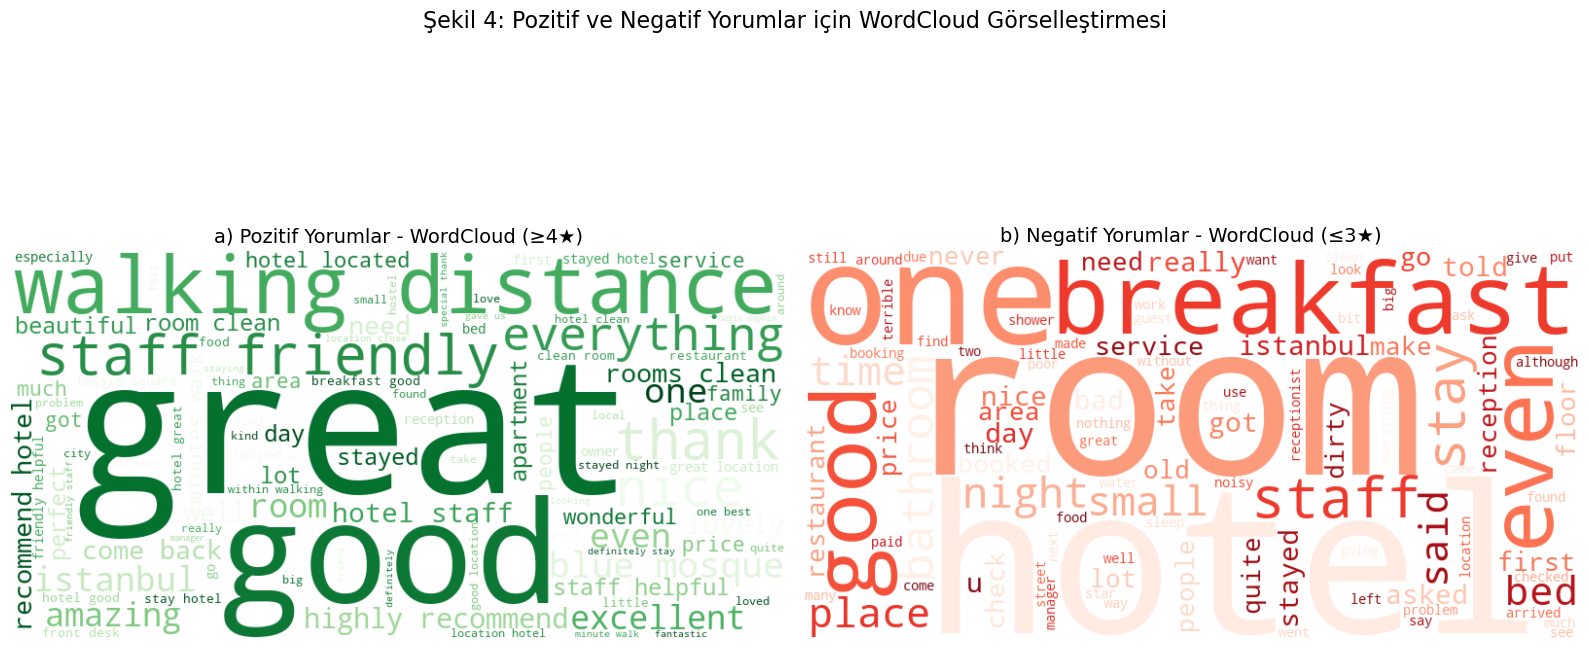

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Pozitif ve negatif yorumları al
positive_text = " ".join(df[df['rating'] >= 4]["clean_text"])
negative_text = " ".join(df[df['rating'] <= 3]["clean_text"])

# Ortak stopwords (zaten temizleme yaptıysan bu adım ekstra koruma sağlar)
stopwords = set(STOPWORDS)

# WordCloud nesneleri
positive_wc = WordCloud(width=800, height=400, background_color="white", colormap="Greens",
                        stopwords=stopwords, max_words=100).generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color="white", colormap="Reds",
                        stopwords=stopwords, max_words=100).generate(negative_text)

# Subgraph ile çizim
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# a) Pozitif WordCloud
axes[0].imshow(positive_wc, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("a) Pozitif Yorumlar - WordCloud (≥4★)", fontsize=14)

# b) Negatif WordCloud
axes[1].imshow(negative_wc, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("b) Negatif Yorumlar - WordCloud (≤3★)", fontsize=14)

plt.suptitle("Şekil 4: Pozitif ve Negatif Yorumlar için WordCloud Görselleştirmesi", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


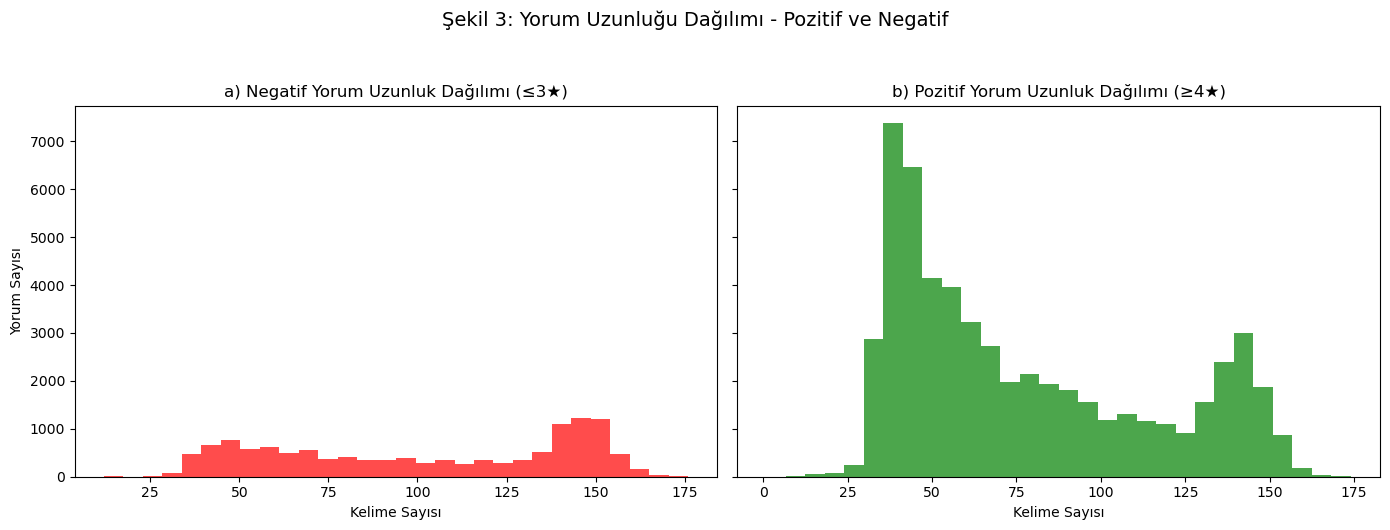

In [14]:
import matplotlib.pyplot as plt

# Yorum uzunluklarını hesapla
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Gruplar
positive_lengths = df[df['rating'] >= 4]['review_length']
negative_lengths = df[df['rating'] <= 3]['review_length']

# Subgraph oluştur
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# a) Negatif yorumlar
axes[0].hist(negative_lengths, bins=30, color='red', alpha=0.7)
axes[0].set_title("a) Negatif Yorum Uzunluk Dağılımı (≤3★)")
axes[0].set_xlabel("Kelime Sayısı")
axes[0].set_ylabel("Yorum Sayısı")

# b) Pozitif yorumlar
axes[1].hist(positive_lengths, bins=30, color='green', alpha=0.7)
axes[1].set_title("b) Pozitif Yorum Uzunluk Dağılımı (≥4★)")
axes[1].set_xlabel("Kelime Sayısı")

# Genel başlık
plt.suptitle("Şekil 3: Yorum Uzunluğu Dağılımı - Pozitif ve Negatif", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


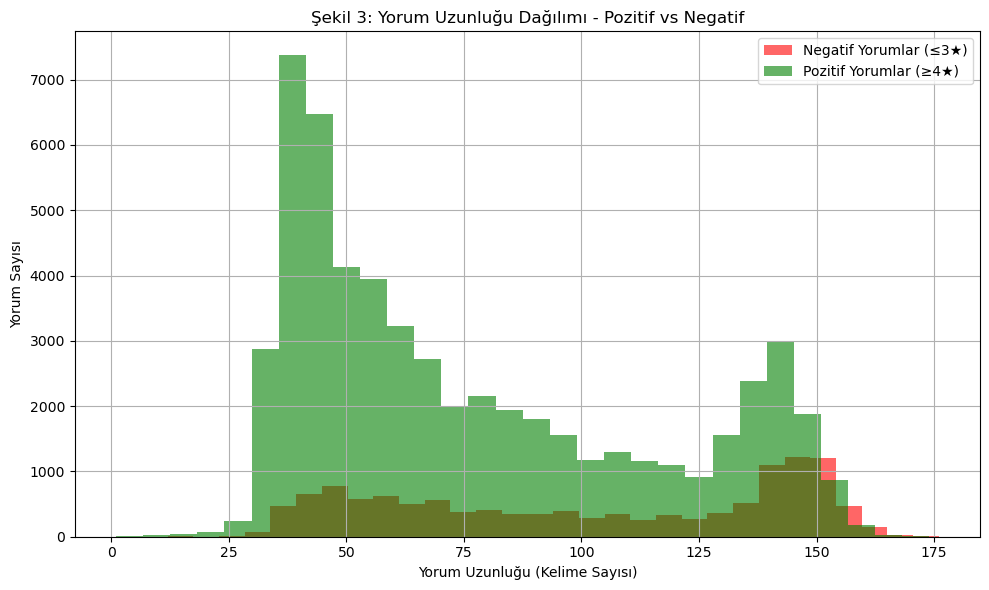

In [15]:
import matplotlib.pyplot as plt

# Yorum uzunluklarını hesapla (kelime bazında)
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Pozitif ve negatif yorumlar
positive_lengths = df[df['rating'] >= 4]['review_length']
negative_lengths = df[df['rating'] <= 3]['review_length']

# Histogram (dağılım) çizimi
plt.figure(figsize=(10, 6))
plt.hist(negative_lengths, bins=30, alpha=0.6, color='red', label='Negatif Yorumlar (≤3★)')
plt.hist(positive_lengths, bins=30, alpha=0.6, color='green', label='Pozitif Yorumlar (≥4★)')
plt.title("Şekil 3: Yorum Uzunluğu Dağılımı - Pozitif vs Negatif")
plt.xlabel("Yorum Uzunluğu (Kelime Sayısı)")
plt.ylabel("Yorum Sayısı")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Küçük harfe çevir
    text = text.lower()
    # Noktalama işaretlerini kaldır
    text = re.sub(r"[^\w\s]", " ", text)
    # Kelimelere böl
    tokens = nltk.word_tokenize(text)
    # Durak kelimeleri çıkar ve kelimeleri köklerine (lemma) indirgeme
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    # Tekrar metne birleştir
    return " ".join(tokens)

# Örnek kullanım:
sample_review = df['review_text'].iloc[0]
print("Orijinal:", sample_review)
print("Ön işlem sonrası:", preprocess_text(sample_review))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Orijinal: Very close to mall and many restaurants. Great location for shopping and dining out. Very professional and polite reception staff. Special thanks to Celal Yayla from the reception staff. Also I highly appreciate another staff who was courteous, polite and attentive, his name is Salahattin Başoğul. Would definitely stay again!
Ön işlem sonrası: close mall many restaurant great location shopping dining professional polite reception staff special thanks celal yayla reception staff also highly appreciate another staff courteous polite attentive name salahattin başoğul would definitely stay


In [7]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# (Opsiyonel) Hızlı deneme amaçlı veri setini bir alt kümeye indirmek:
# df = df.sample(20000, random_state=42)

# Tabakalı şekilde eğitim (%80) ve test (%20) olarak ayır
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating'])
print("Eğitim veri sayısı:", len(train_df), "Test veri sayısı:", len(test_df))

# Model için etiketleri 0-4 aralığına çek (1★->0, 2★->1, ..., 5★->4)
train_df['label'] = train_df['rating'] - 1
test_df['label'] = test_df['rating'] - 1

# HuggingFace Dataset formatına dönüştür (sadece review_text ve label alanlarıyla)
train_dataset = Dataset.from_pandas(train_df[['review_text','label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['review_text','label']].reset_index(drop=True))


Eğitim veri sayısı: 55028 Test veri sayısı: 13757



DistilBERT modeli eğitiliyor...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/55028 [00:00<?, ? examples/s]

Map:   0%|          | 0/13757 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.600800,0.565243,0.766810,0.592257,0.753954,0.977920
2,0.496100,0.585491,0.760922,0.604339,0.755453,0.978375


DistilBERT eğitimi 646.74 saniye sürdü


DistilBERT değerlendirme metrikleri: {'eval_loss': 0.5854910612106323, 'eval_accuracy': 0.7609217125826852, 'eval_f1_macro': 0.6043393099034644, 'eval_f1_weighted': 0.7554529593130147, 'eval_roc_auc': 0.9783752821398655, 'eval_runtime': 22.2682, 'eval_samples_per_second': 617.787, 'eval_steps_per_second': 38.62, 'epoch': 2.0}
DistilBERT karışıklık matrisi:
 [[ 773  129   52   11   12]
 [ 163  183  148   23    4]
 [  51  134  444  350   58]
 [   3   15  200 1335 1107]
 [   3    5   30  791 7733]]

BERT modeli eğitiliyor...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/55028 [00:00<?, ? examples/s]

Map:   0%|          | 0/13757 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.600500,0.561325,0.765429,0.599679,0.758000,0.978962
2,0.478000,0.578272,0.761939,0.604232,0.757176,0.979996


BERT eğitimi 1237.87 saniye sürdü


BERT değerlendirme metrikleri: {'eval_loss': 0.5782715678215027, 'eval_accuracy': 0.7619393763175111, 'eval_f1_macro': 0.6042323118187575, 'eval_f1_weighted': 0.7571755145073997, 'eval_roc_auc': 0.9799963582382731, 'eval_runtime': 42.6175, 'eval_samples_per_second': 322.802, 'eval_steps_per_second': 20.179, 'epoch': 2.0}
BERT karışıklık matrisi:
 [[ 761  150   48    5   13]
 [ 156  171  163   25    6]
 [  43  123  467  353   51]
 [   4   13  198 1357 1088]
 [   4    2   21  809 7726]]

RoBERTa modeli eğitiliyor...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/55028 [00:00<?, ? examples/s]

Map:   0%|          | 0/13757 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.612400,0.585768,0.761212,0.611975,0.756478,0.978953
2,0.515800,0.564781,0.767391,0.611450,0.761134,0.980552


RoBERTa eğitimi 1244.67 saniye sürdü


RoBERTa değerlendirme metrikleri: {'eval_loss': 0.5647814273834229, 'eval_accuracy': 0.767391146325507, 'eval_f1_macro': 0.6114496532340565, 'eval_f1_weighted': 0.7611341208565112, 'eval_roc_auc': 0.9805523420640704, 'eval_runtime': 41.7407, 'eval_samples_per_second': 329.583, 'eval_steps_per_second': 20.603, 'epoch': 2.0}
RoBERTa karışıklık matrisi:
 [[ 796  107   57    6   11]
 [ 168  168  163   16    6]
 [  52  116  475  335   59]
 [   4    6  211 1348 1091]
 [   3    4   25  760 7770]]

DeBERTa modeli eğitiliyor...


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/55028 [00:00<?, ? examples/s]

Map:   0%|          | 0/13757 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.589500,0.556457,0.768409,0.599386,0.754501,0.979974
2,0.482000,0.563340,0.769572,0.623404,0.764324,0.981447


DeBERTa eğitimi 1697.60 saniye sürdü


DeBERTa değerlendirme metrikleri: {'eval_loss': 0.5633400678634644, 'eval_accuracy': 0.7695718543287053, 'eval_f1_macro': 0.6234042118587433, 'eval_f1_weighted': 0.7643235602821581, 'eval_roc_auc': 0.9814465246309291, 'eval_runtime': 59.8833, 'eval_samples_per_second': 229.73, 'eval_steps_per_second': 14.361, 'epoch': 2.0}
DeBERTa karışıklık matrisi:
 [[ 791  121   46    5   14]
 [ 162  196  136   20    7]
 [  49  129  488  321   50]
 [   5    8  207 1358 1082]
 [   3    3   21  781 7754]]


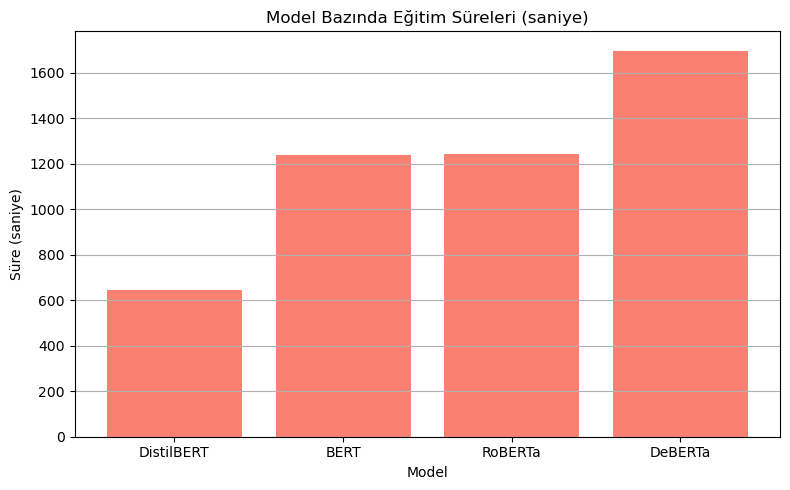

In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from datasets import Dataset

training_durations = {}  # Eğitim sürelerini burada tutacağız

def train_and_evaluate(model_name: str, model_checkpoint: str, train_data: Dataset, test_data: Dataset, epochs: int = 2, batch_size: int = 16):
    print(f"\n{model_name} modeli eğitiliyor...")

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=5)
    
    def tokenize_batch(batch):
        return tokenizer(batch['review_text'], truncation=True, padding=True, max_length=128)

    train_enc = train_data.map(tokenize_batch, batched=True)
    test_enc = test_data.map(tokenize_batch, batched=True)

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = np.argmax(pred.predictions, axis=1)
        acc = accuracy_score(labels, preds)
        f1_macro = f1_score(labels, preds, average='macro')
        f1_weighted = f1_score(labels, preds, average='weighted')
        binary_labels = [1 if l >= 3 else 0 for l in labels]
        probs = np.exp(pred.predictions) / np.exp(pred.predictions).sum(axis=1, keepdims=True)
        pos_probs = probs[:, 3] + probs[:, 4]
        try:
            roc = roc_auc_score(binary_labels, pos_probs)
        except ValueError:
            roc = np.nan
        return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted, "roc_auc": roc}

    training_args = TrainingArguments(
        output_dir=f"{model_name}_results",
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=500,
        load_best_model_at_end=False,
        seed=42,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_enc,
        eval_dataset=test_enc,
        compute_metrics=compute_metrics
    )

    # Eğitim süresini ölç
    start_time = time.time()
    trainer.train()
    end_time = time.time()
    
    training_time = end_time - start_time
    training_durations[model_name] = training_time
    print(f"{model_name} eğitimi {training_time:.2f} saniye sürdü")

    eval_metrics = trainer.evaluate(test_enc)
    preds = np.argmax(trainer.predict(test_enc).predictions, axis=1)
    cm = confusion_matrix(test_enc['label'], preds)

    print(f"{model_name} değerlendirme metrikleri:", eval_metrics)
    print(f"{model_name} karışıklık matrisi:\n", cm)
    
    return eval_metrics, cm, trainer.model


# Eğitilecek modeller
models = {
    "DistilBERT": "distilbert-base-uncased",
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DeBERTa": "microsoft/deberta-base"
}

results = {}
confusion_matrices = {}
trained_models = {}

for name, checkpoint in models.items():
    metrics, cm, model = train_and_evaluate(name, checkpoint, train_dataset, test_dataset, epochs=2, batch_size=16)
    results[name] = metrics
    confusion_matrices[name] = cm
    trained_models[name] = model

# Eğitim sürelerini bar chart ile çiz
plt.figure(figsize=(8, 5))
plt.bar(training_durations.keys(), training_durations.values(), color='salmon')
plt.title("Model Bazında Eğitim Süreleri (saniye)")
plt.ylabel("Süre (saniye)")
plt.xlabel("Model")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [9]:
# Eğitilen her modelin metriklerini yazdıralım
for name, metrics in results.items():
    acc = metrics['eval_accuracy']
    f1 = metrics['eval_f1_macro']
    roc = metrics['eval_roc_auc']
    print(f"{name}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}, ROC-AUC={roc:.3f}")


DistilBERT: Accuracy=0.761, Macro-F1=0.604, ROC-AUC=0.978
BERT: Accuracy=0.762, Macro-F1=0.604, ROC-AUC=0.980
RoBERTa: Accuracy=0.767, Macro-F1=0.611, ROC-AUC=0.981
DeBERTa: Accuracy=0.770, Macro-F1=0.623, ROC-AUC=0.981


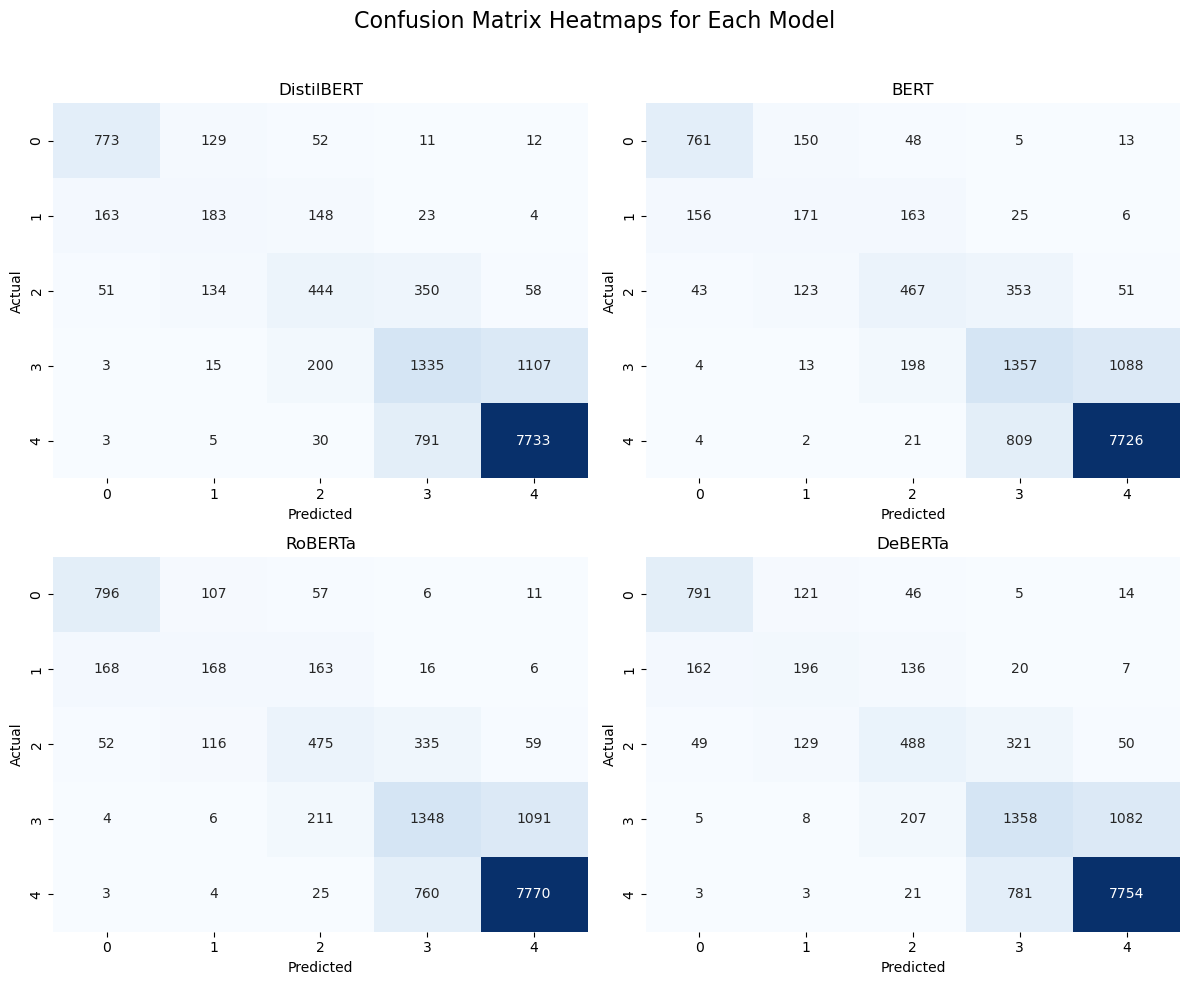

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix görselleştirmesi
model_names = ["DistilBERT", "BERT", "RoBERTa", "DeBERTa"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Confusion Matrix Heatmaps for Each Model", fontsize=16)

for ax, name in zip(axes.flat, model_names):
    cm = confusion_matrices[name]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f"{name}", fontsize=12)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # başlıkla çakışmasın
plt.show()


100%|██████████| 300/300 [00:03<00:00, 75.22it/s]


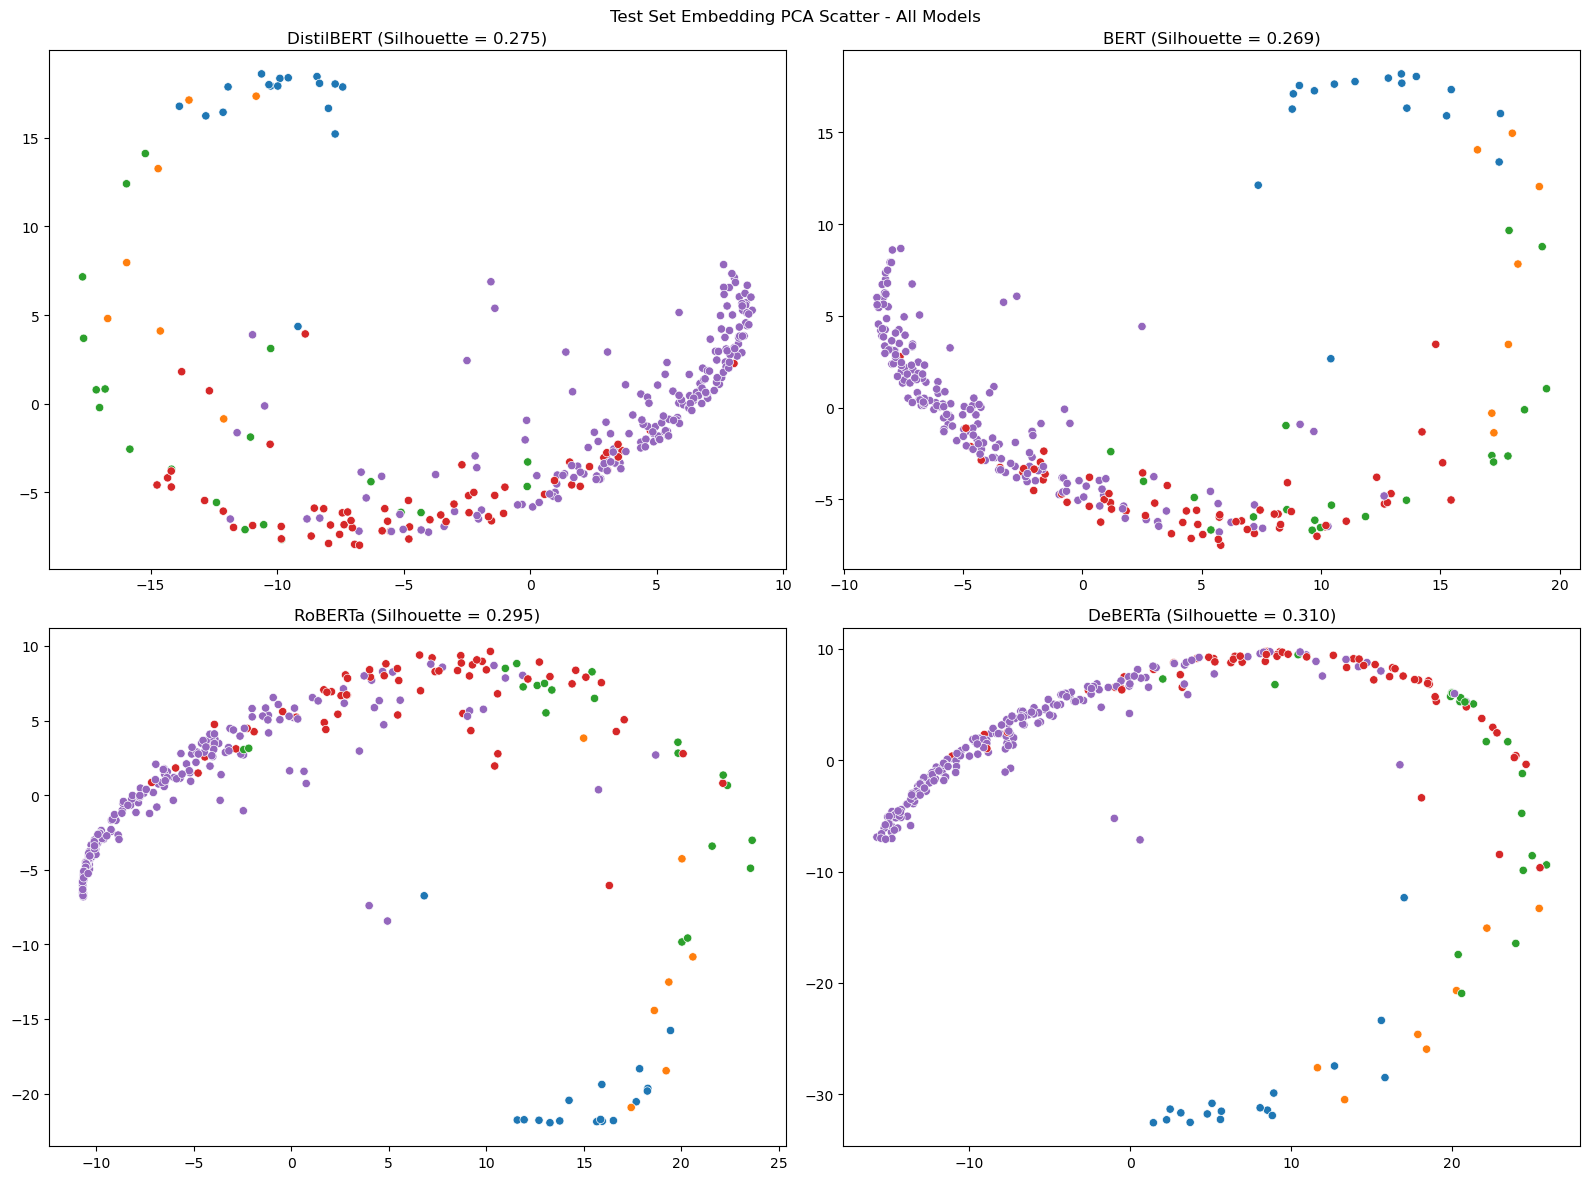


Silhouette Skorları:
DistilBERT: 0.275
BERT: 0.269
RoBERTa: 0.295
DeBERTa: 0.310


In [11]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

from tqdm import tqdm

def extract_embeddings(model, tokenizer, texts):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts):
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True, return_dict=True)
            hidden_states = outputs.hidden_states[-1]  # last layer
            cls_embedding = hidden_states[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

# Örnekleme yapalım (tüm test seti yerine 300 yorum seçelim)
sample_df = test_df.sample(300, random_state=42).reset_index(drop=True)
sample_texts = sample_df['review_text'].tolist()
sample_labels = sample_df['rating'].values

# Tüm modeller için embed ve PCA
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

silhouette_scores = {}

for i, (name, model) in enumerate(trained_models.items()):
    tokenizer = AutoTokenizer.from_pretrained(models[name], use_fast=False)
    embeds = extract_embeddings(model, tokenizer, sample_texts)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeds)
    sil_score = silhouette_score(reduced, sample_labels)
    silhouette_scores[name] = sil_score

    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=sample_labels, palette='tab10', ax=axes[i], legend=False)
    axes[i].set_title(f"{name} (Silhouette = {sil_score:.3f})")

plt.suptitle("Test Set Embedding PCA Scatter - All Models")
plt.tight_layout()
plt.show()

# Sonuçları yazdıralım
print("\nSilhouette Skorları:")
for name, score in silhouette_scores.items():
    print(f"{name}: {score:.3f}")


In [12]:
import torch

deberta_model = trained_models["DeBERTa"]
deberta_model.eval()

deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base", use_fast=False)

def predict_rating(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding='max_length')
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits.detach().cpu().numpy()
    pred_label = logits.argmax(axis=1)[0]
    return pred_label + 1

# Test setinden örnek yorumlar
sample_reviews = test_df.sample(5, random_state=1)

for idx, row in sample_reviews.iterrows():
    text = row['review_text']
    actual = row['rating']
    pred = predict_rating(text, deberta_model, deberta_tokenizer)
    
    if abs(pred - actual) > 1 and not (pred >= 4 and actual >= 4) and not (pred <= 2 and actual <= 2):
        consistency = "TUTARSIZ"
    else:
        consistency = "TUTARLI"
    
    print(f"Yorum:\n{text}\n")
    print(f"Gerçek puan: {actual}★, Model tahmini: {pred}★ -> {consistency}\n{'-'*80}\n")


Yorum:
Although I am turkish I am writing in english so all international guests can escape from staying at this horrible hotel. We booked the hotel for 2 days as my father is in Intensive care unit at hospital nearby thinking that it is a wyndham hotel without knowing it is only a unqualified franchise!  As they said we can pay day by day, we paid for the first night saying that we will pay for the second day the next morning. Guess what? After no sleep for 36hours at the hospital, while we checked in and sleeping at 21h49 they called us to tell they received an online reservation for our suit room starting from tomorrow although the reception guy told us initially that he booked for 2 days and closed our room for reservation for others'online booking. When I asked them what it means

Gerçek puan: 1★, Model tahmini: 1★ -> TUTARLI
--------------------------------------------------------------------------------

Yorum:
I stayed at this hotel while working in Kadıköy and I'm afraid I wou


1. YORUM:
Although I am turkish I am writing in english so all international guests can escape from staying at this horrible hotel. We booked the hotel for 2 days as my father is in Intensive care unit at hospital nearby thinking that it is a wyndham hotel without knowing it is only a unqualified franchise!  As they said we can pay day by day, we paid for the first night saying that we will pay for the second day the next morning. Guess what? After no sleep for 36hours at the hospital, while we checked in and sleeping at 21h49 they called us to tell they received an online reservation for our suit room starting from tomorrow although the reception guy told us initially that he booked for 2 days and closed our room for reservation for others'online booking. When I asked them what it means



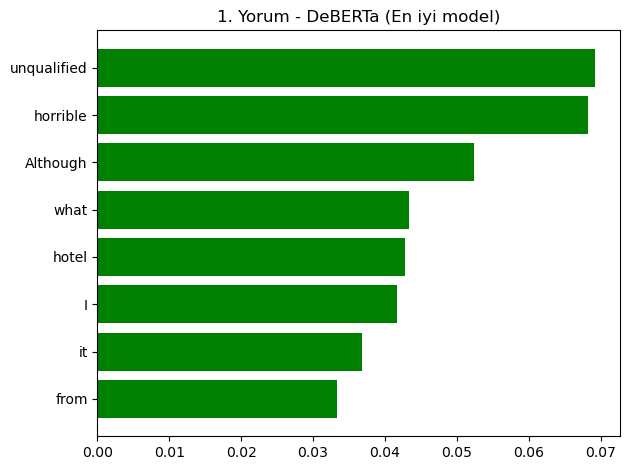

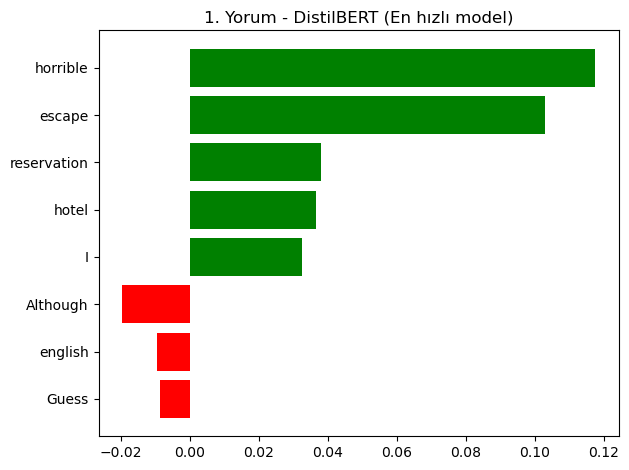


2. YORUM:
I stayed at this hotel while working in Kadıköy and I'm afraid I would not stay here again. My colleagues received newly refurbished rooms. I got a standard old style room the smelled unpleasant. The benefits are location and proximity to ferry port. The hotel is cheap but I did not think it was very modern. Large room. The photos don't look like my room. If you are happy with cheap and basic it will do. Just not for me.



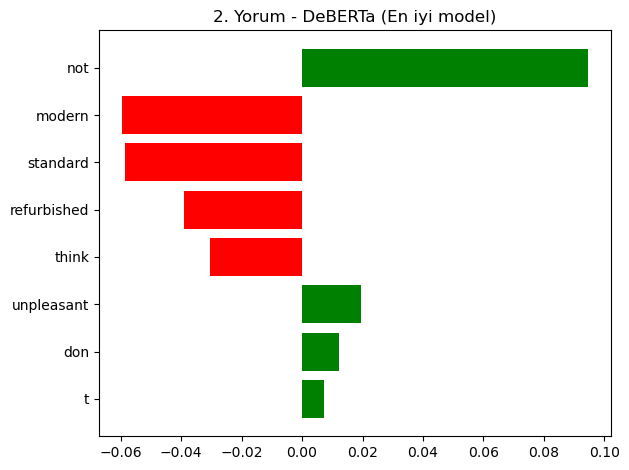

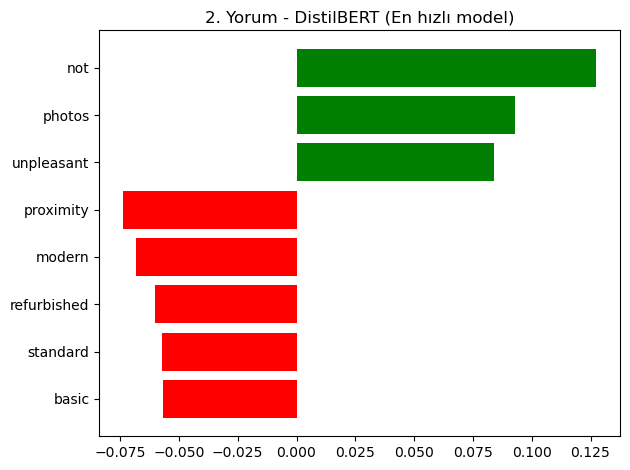


3. YORUM:
I have just spent two nights at La Maison, while working in Istanbul. I had a lovely room with a great view of the Bosphorus. The Hotel is situated on quite a steep hill, which I walked down a couple off times to the Ciragan Palace Kempinski Hotel where some colleagues where staying, and went out to eat nearby. On other occasions the Hotel found me a Taxi, that generally turned up very promptly. Other than breakfast, I did not get the chance to eat in the evening at the Hotel.  I will return to Istanbul at some point not working, and would consider staying again



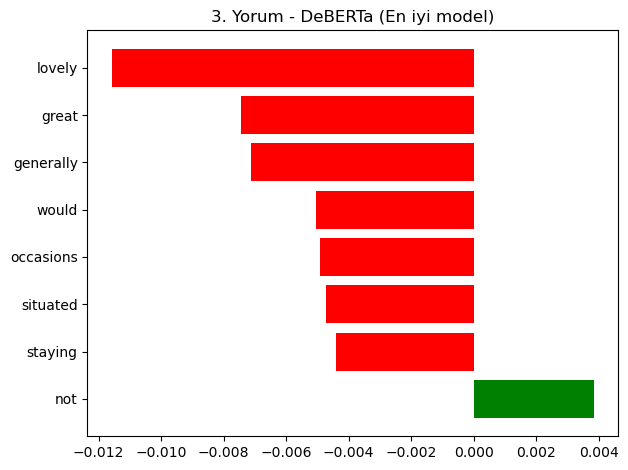

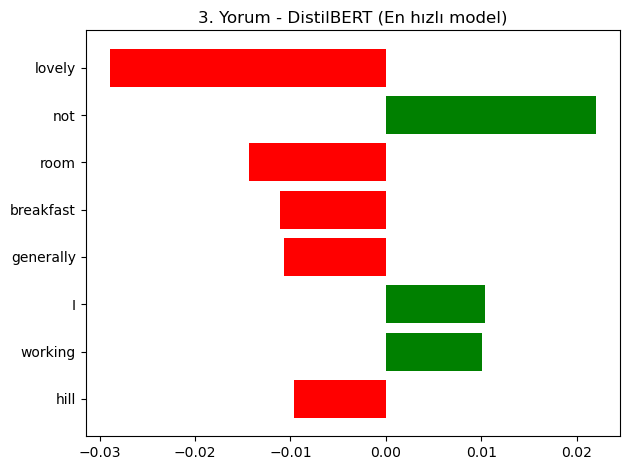


4. YORUM:
With a charming location on the riverside and rustic chalet style buildings scattered throughout the flowering gardens, Robin's nest has a lot to offer. The highlights are eating on the porch overhanging the water and swimming in the large and spotless pool. The rooms are clean with wood paneling and balconies . Request one on the river side not the road. It is a long walk or short drive to town. A shorter walk to the beach.  The service was extremely friendly but certain aspects that I found charmingly reminiscent of hotels 20 years ago, might not appeal to everyone. The large menu only had about one quarter of the items listed. The bar has all kinds of special drinks but only one or two bottles of wine from the list of about a dozen and those were on the verge of turning. 



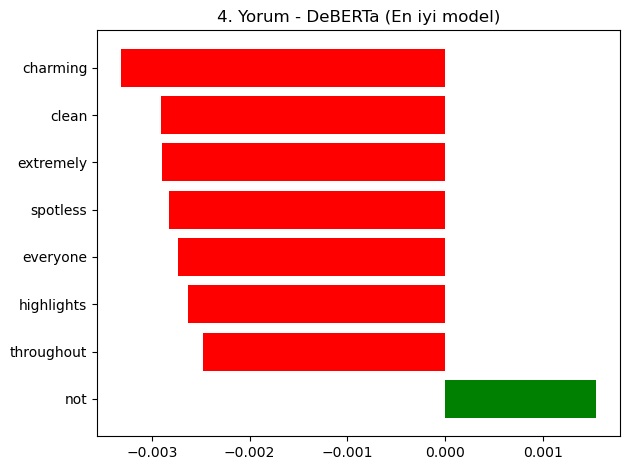

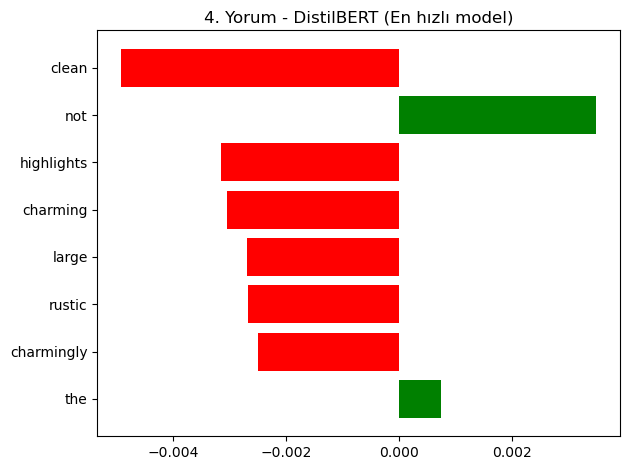


5. YORUM:
The location, architectural details, the service quality... cosiness , the view and the decoration is unique...The owners are superb personalities with taste, knowledge and refinement..It's a "must do" experience for Istanbul



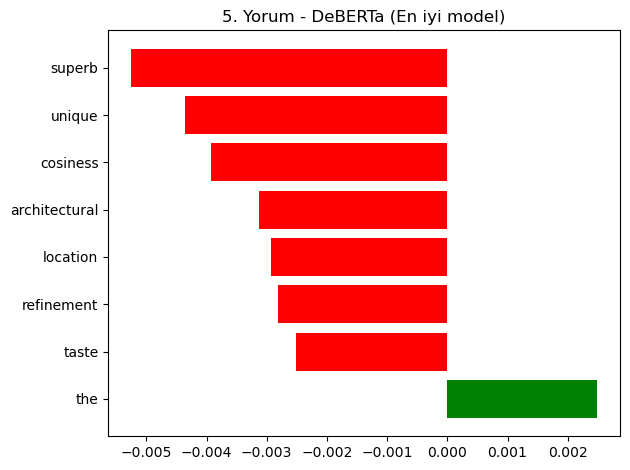

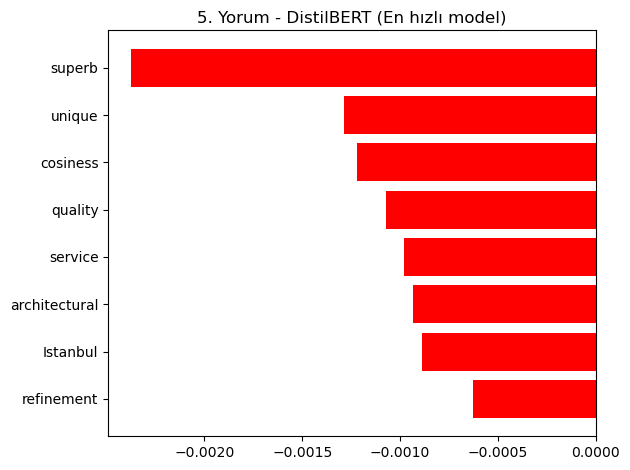

In [10]:
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

# Stil açık
plt.style.use('default')

# Model ve tokenizer'lar
deberta_model = trained_models["DeBERTa"]
distilbert_model = trained_models["DistilBERT"]

deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base", use_fast=False)
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=False)

def predict_proba_deberta(texts):
    inputs = deberta_tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(deberta_model.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = deberta_model(**inputs).logits.cpu().numpy()
    return np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)

def predict_proba_distilbert(texts):
    inputs = distilbert_tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(distilbert_model.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = distilbert_model(**inputs).logits.cpu().numpy()
    return np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)

# Sınıf adları
class_names = ['1★', '2★', '3★', '4★', '5★']

# Yorum listesi
sample_texts = sample_reviews['review_text'].tolist()

# Her yorum için ayrı ayrı açıklama ve grafik (üst üste)
for i, text in enumerate(sample_texts):
    explainer = LimeTextExplainer(class_names=class_names)

    exp_deberta = explainer.explain_instance(text, predict_proba_deberta, num_features=8, labels=[0,1,2,3,4], num_samples=2000)
    exp_distil = explainer.explain_instance(text, predict_proba_distilbert, num_features=8, labels=[0,1,2,3,4], num_samples=2000)

    print(f"\n{i+1}. YORUM:\n{text}\n")

    # DeBERTa grafiği
    fig1 = exp_deberta.as_pyplot_figure(label=exp_deberta.available_labels()[0])
    plt.title(f"{i+1}. Yorum - DeBERTa (En iyi model)")
    plt.tight_layout()
    plt.show()

    # DistilBERT grafiği
    fig2 = exp_distil.as_pyplot_figure(label=exp_distil.available_labels()[0])
    plt.title(f"{i+1}. Yorum - DistilBERT (En hızlı model)")
    plt.tight_layout()
    plt.show()
